### Telecommunication Company’s Customer Churn Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau, chi2_contingency, chi2, f_oneway, t, f
from scipy.spatial.distance import correlation

In [2]:
# Load the data from Telco-Customer-Churn.xlsx
df = pd.read_excel('/Users/sally/Desktop/ADSP 31007 Stats/Individual Assignment/Individual Assignment 3/Telco-Customer-Churn.xlsx')

# Drop rows with NaN values
df = df.dropna(subset=['MonthlyCharges', 'TotalCharges', 'Tenure'])

# Calculate average monthly charges
df['Average_monthly_charges'] = df['TotalCharges'] / df['Tenure']

#### Hypothesis 1: Monthly Charges and Churn

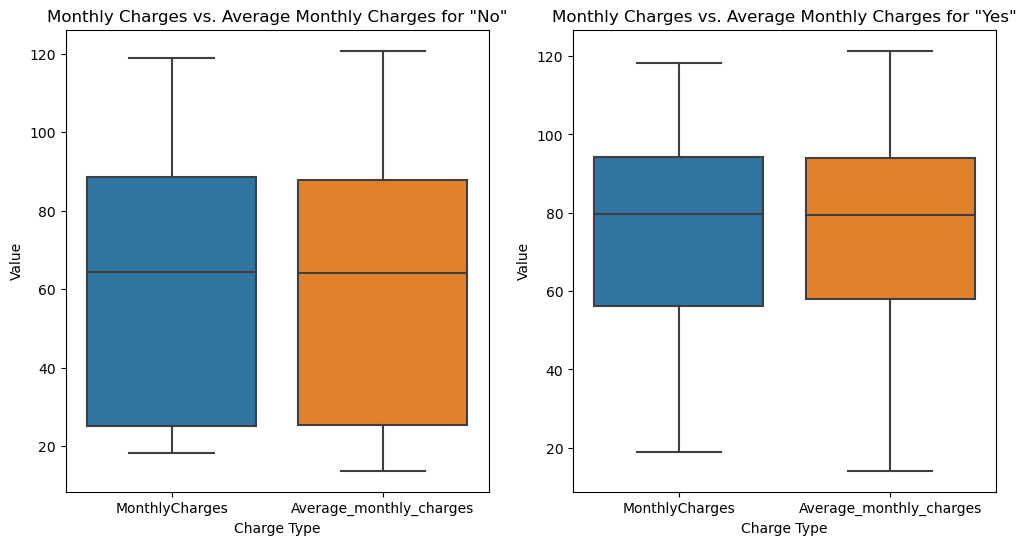

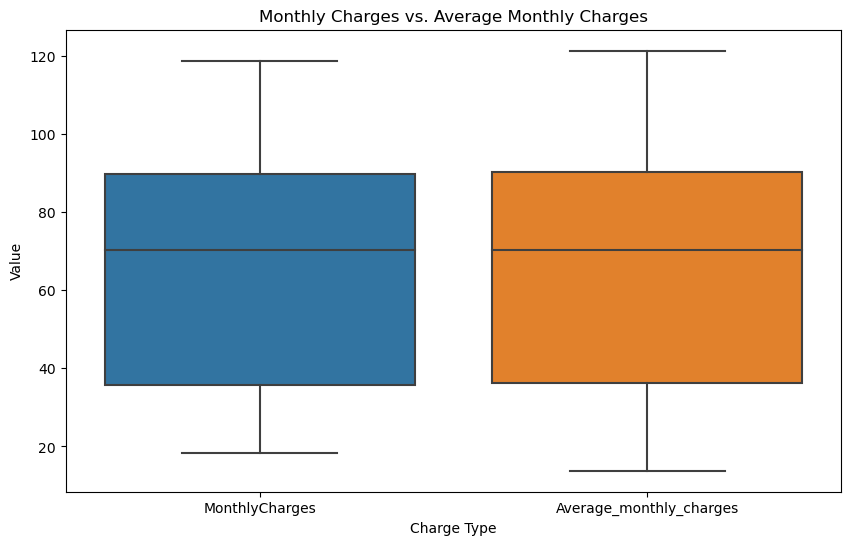

In [3]:
# Generate a chart with vertical boxplots labeled by Churn status
df_no = df[df["Churn"]=="No"][["CustomerID", "MonthlyCharges", "Average_monthly_charges"]]
df_yes = df[df["Churn"]=="Yes"][["CustomerID", "MonthlyCharges", "Average_monthly_charges"]]

df_no_melted = pd.melt(df_no, id_vars='CustomerID', var_name='Numeric_Variable', value_name='Value')
df_yes_melted = pd.melt(df_yes, id_vars='CustomerID', var_name='Numeric_Variable', value_name='Value')

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x='Numeric_Variable', y='Value', data=df_no_melted, ax=axes[0])
sns.boxplot(x='Numeric_Variable', y='Value', data=df_yes_melted, ax=axes[1])

axes[0].set_title('Monthly Charges vs. Average Monthly Charges for "No"')
axes[0].set_xlabel('Charge Type')
axes[0].set_ylabel('Value')

axes[1].set_title('Monthly Charges vs. Average Monthly Charges for "Yes"')
axes[1].set_xlabel('Charge Type')
axes[1].set_ylabel('Value')
plt.show()

# Generate a chart with vertical boxplots of Monthly Charges and Average Monthly Charges
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['MonthlyCharges', 'Average_monthly_charges']])
plt.title('Monthly Charges vs. Average Monthly Charges')
plt.xlabel('Charge Type')
plt.ylabel('Value')
plt.show()

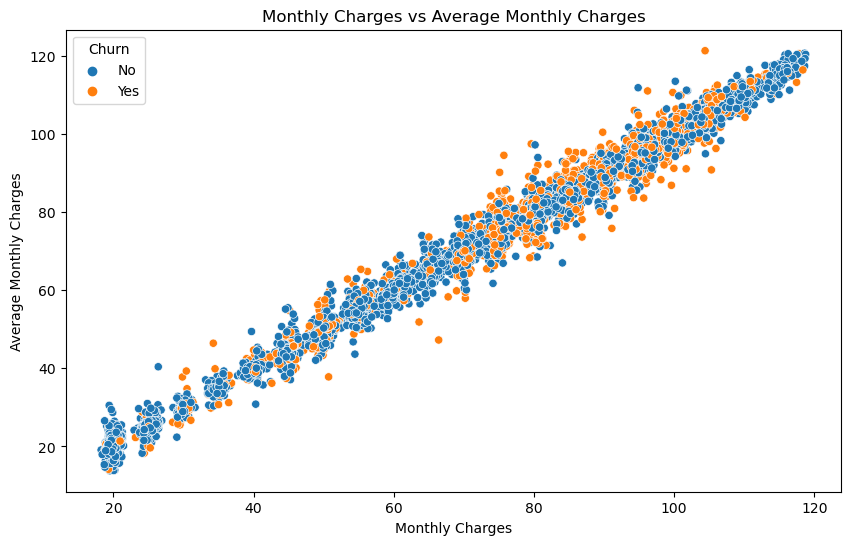

In [4]:
# Generate a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonthlyCharges', y='Average_monthly_charges', hue='Churn', data=df)
plt.title('Monthly Charges vs Average Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Average Monthly Charges')
plt.show()

In [5]:
# Calculate Pearson, Spearman’s Rank-Order, Kendall’s Tau-b correlations
pearson_corr, _ = pearsonr(df['MonthlyCharges'], df['Average_monthly_charges'])
spearman_corr, _ = spearmanr(df['MonthlyCharges'], df['Average_monthly_charges'])
kendall_corr, _ = kendalltau(df['MonthlyCharges'], df['Average_monthly_charges'])

print('=== Correlation Measures ===')
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman's Rank-Order Correlation: {spearman_corr}")
print(f"Kendall's Tau-b Correlation: {kendall_corr}")

# Calculate Distance correlations
def AdjustedDistance (x):
   '''Compute the adjusted distances for an array x

   Argument:
   ---------
   x : a Pandas Series

   Output:
   -------
   adj_distance : Adjusted distances
   '''

   a_matrix = []
   row_mean = []

   for xi in x:
      a_row = np.abs(x - xi)
      row_mean.append(np.mean(a_row))
      a_matrix.append(a_row)
   total_mean = np.mean(row_mean)

   adj_m = []
   for row, rm in zip(a_matrix, row_mean):
      row = (row - row_mean) - (rm - total_mean)
      adj_m.append(row)

   return (np.array(adj_m))
   
def DistanceCorrelation (x, y):
   '''Compute the Distance correlation between two arrays x and y
   with the same number of values

   Argument:
   ---------
   x : a Pandas Series
   y : a Pandas Series
   
   Output:
   -------
   dcorr : Distance correlation
   '''

   adjD_x = AdjustedDistance (x)
   adjD_y = AdjustedDistance (y)

   v2sq_x = np.mean(np.square(adjD_x))
   v2sq_y = np.mean(np.square(adjD_y))
   v2sq_xy = np.mean(adjD_x * adjD_y)
   
   if (v2sq_x > 0.0 and v2sq_y > 0.0):
      dcorr = (v2sq_xy / v2sq_x) * (v2sq_xy / v2sq_y)
      dcorr = np.power(dcorr, 0.25)
   else:
      dcorr = np.nan

   return (dcorr)

# Apply the AdjustedDistance function
adjusted_distance = AdjustedDistance (df['MonthlyCharges'])

# Apply the DistanceCorrelation function
distance_corr = DistanceCorrelation (df['MonthlyCharges'], df['Average_monthly_charges'])
print(f"Distance Correlation: {distance_corr}")

=== Correlation Measures ===
Pearson Correlation: 0.9962373123907768
Spearman's Rank-Order Correlation: 0.9917562816538894
Kendall's Tau-b Correlation: 0.9271331330292459
Distance Correlation: 0.9954266667578495


#### Hypothesis 2: Churn and Payment Methods

In [6]:
# Load the data from Telco-Customer-Churn.xlsx
df = pd.read_excel('/Users/sally/Desktop/ADSP 31007 Stats/Individual Assignment/Individual Assignment 3/Telco-Customer-Churn.xlsx')

# Cross-tabulate payment method by the churn indicator
cross_table = pd.crosstab(df['PaymentMethod'], df['Churn'])

# Display the cross-tabulation
print("Cross-tabulation of Payment Method:")
print(cross_table)

Cross-tabulation of Payment Method:
Churn                        No   Yes
PaymentMethod                        
Bank transfer (automatic)  1286   258
Credit card (automatic)    1290   232
Electronic check           1294  1071
Mailed check               1304   308


In [7]:
# Define a function that performs the Pearson Chi-square test
#   xCat - Input categorical feature (array-like or Series)
#   yCat - Input categorical target field (array-like or Series)
def PearsonChiSquareTest (xCat, yCat):
   '''Perform the Pearson test of independence and compute the Cramer V

   Argument:
   ---------
   xCat : a Pandas Series of categorical observations
   yCat : another Pandas Series of categorical observations

   Output:
   -------
   xNCat     : Number of X categories
   yNCat     : Number of Y categories
   chiSqStat : Test statistic
   chiSqDf   : Test degrees of freedom
   chiSqSig  : Test significance
   cramerv   : Cramer V
   '''

   # Question 2a Generate the crosstabulation
   obsCount = pd.crosstab(index = xCat, columns = yCat, margins = False, dropna = True)
   xNCat = obsCount.shape[0]
   yNCat = obsCount.shape[1]
   cTotal = obsCount.sum(axis = 1)
   rTotal = obsCount.sum(axis = 0)
   nTotal = np.sum(rTotal)
   expCount = np.outer(cTotal, (rTotal / nTotal))

   # Question 2b 2c Calculate the Chi-Square statistics
   chiSqStat = ((obsCount - expCount)**2 / expCount).to_numpy().sum()
   chiSqDf = (xNCat - 1) * (yNCat - 1)
   if (chiSqDf > 0):
      chiSqSig = chi2.sf(chiSqStat, chiSqDf)
      cramerv = chiSqStat / nTotal / (min(xNCat, yNCat) - 1.0)
      cramerv = np.sqrt(cramerv)
   else:
      chiSqSig = np.NaN
      cramerv = np.NaN

   outlist = [xNCat, yNCat, chiSqStat, chiSqDf, chiSqSig, cramerv]
   return (outlist)

outlist = PearsonChiSquareTest(df['PaymentMethod'], df['Churn'])
xNCat, yNCat, chiSqStat, chiSqDf, chiSqSig, cramerv = outlist

print(f'\n=== Pearson Chi-Square Test ===')
print(f"Chi-Square Value: {chiSqStat}")
print(f"Degrees of Freedom: {chiSqDf}")
print(f"P-value: {format(chiSqSig, '.2e')}")
print(f"\n=== Cramer's V Value ===")
print(f"Cramer's V Value: {cramerv}")


=== Pearson Chi-Square Test ===
Chi-Square Value: 648.1423274814001
Degrees of Freedom: 3
P-value: 3.68e-140

=== Cramer's V Value ===
Cramer's V Value: 0.3033586255540706


#### Hypothesis 3: Churn Status Impact on Monthly Charges

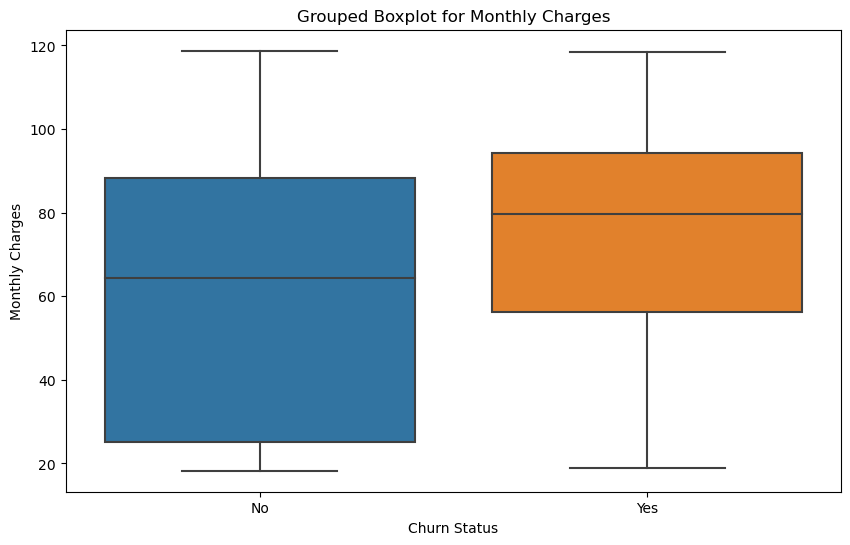

In [8]:
# Generate a grouped boxplot for MonthlyCharges with Churn as the grouping variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Grouped Boxplot for Monthly Charges')
plt.xlabel('Churn Status')
plt.ylabel('Monthly Charges')
plt.show()

In [9]:
# Calculate the Counts, Means, and Standard Deviations of MonthlyCharges within each Churn category
grouped_stats = df.groupby('Churn')['MonthlyCharges'].agg(['count', 'mean', 'std'])
print("\nCounts, Means, and Standard Deviations of MonthlyCharges within each Churn category:")
print(grouped_stats)


Counts, Means, and Standard Deviations of MonthlyCharges within each Churn category:
       count       mean        std
Churn                             
No      5174  61.265124  31.092648
Yes     1869  74.441332  24.666053


In [10]:
# Calculate the Eta-Squared statistic
# Define a function that performs the ANOVA test 
#   xCat - Input categorical feature (array-like or Series)
#   yCont - Input continuous target field (array-like or Series)

def AnalysisOfVarianceTest (xCat, yCont):
   '''Perform the Pearson test of independence and compute the Cramer V

   Argument:
   ---------
   xCat  : a Pandas Series of categorical observations
   yCont : a Pandas Series of continuous observations

   Output:
   -------
   nGroup : Number of X categories
   etasq  : Eta-Squared value
   '''

   df = pd.DataFrame(columns = ['x', 'y'])
   df['x'] = xCat
   df['y'] = yCont

   # Total Count and Sum of Squares
   totalCount = df['y'].count()
   totalSSQ = df['y'].var(ddof = 0) * totalCount

   # Within Group Count and Sums of Squares
   groupCount = df.groupby('x').count()
   groupSSQ = df.groupby('x').var(ddof = 0) * groupCount
   nGroup = groupCount.shape[0]

   withinSSQ = np.sum(groupSSQ.values)

   if (totalSSQ > 0.0):
      etasq = 1.0 - withinSSQ / totalSSQ
   else:
      etasq = np.NaN
       
   outlist = [nGroup, etasq]
   return (outlist)

# Apply the AnalysisOfVarianceTest function
eta_squared = AnalysisOfVarianceTest(df['Churn'], df['MonthlyCharges'])[1]
print(f"\nEta-Squared Statistic: {eta_squared}")


Eta-Squared Statistic: 0.037386706020624216


#### Hypothesis 4: Variations in Monthly Charges

In [11]:
# Extract MonthlyCharges for customers with and without churn
monthly_charges_churn_no = df.loc[df['Churn'] == 'No', 'MonthlyCharges']
monthly_charges_churn_yes = df.loc[df['Churn'] == 'Yes', 'MonthlyCharges']

# Specify the sample size
n0 = len(monthly_charges_churn_no)
n1 = len(monthly_charges_churn_yes)

# Calculate sample means and variances
mean0 = np.mean(monthly_charges_churn_no)
mean1 = np.mean(monthly_charges_churn_yes)
var0 = np.var(monthly_charges_churn_no, ddof=1)
var1 = np.var(monthly_charges_churn_yes, ddof=1)

# Welch’s t statistic
vn0 = var0 / n0
vn1 = var1 / n1
welch_t = (mean1 - mean0) / np.sqrt(vn0 + vn1)

# Calculate the degrees of freedom using ttest_ind_from_stats
satterthwaite_df = ((vn0 + vn1) ** 2) / ((vn0 ** 2 / (n0 - 1)) + (vn1 ** 2 / (n1 - 1)))


# Test significance value and conclusion
alpha = 0.05  # significance level
p_value_welch = 2.0 * t.sf(abs(welch_t),satterthwaite_df)

# Snedecor-Cochran F test for population variances

SC_f = var0 / var1
df_1 = n0 - 1
df_2 = n1 - 1
f_pvalue = f.sf(SC_f, df_1, df_2) + f.cdf(1 / SC_f, df_2, df_1)

# Print the calculated statistics
print(f"\n=== Statistics ===")
print(f"a) Welch’s t statistic: {welch_t}")
print(f"b) Satterthwaite degree of freedom: {satterthwaite_df}")
print(f"c) Test Significance Value: {p_value_welch}")

# Print the Snedecor-Cochran F test results
print('=== Snedecor and Cochran for Equality of Population Variances ===')
print('F Statistic = {:,.7f}'.format(SC_f))
print('Degree of Freedom = {:,.7f}, {:,.7f}'.format(df_1, df_2))
print('Significance = {:,.7f}'.format(f_pvalue))



=== Statistics ===
a) Welch’s t statistic: 18.40752667641466
b) Satterthwaite degree of freedom: 4135.795017764662
c) Test Significance Value: 8.592449331549498e-73
=== Snedecor and Cochran for Equality of Population Variances ===
F Statistic = 1.5889714
Degree of Freedom = 5,173.0000000, 1,868.0000000
Significance = 0.0000000
